In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_runner
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dataclasses
import pandas as pd
import statsmodels.api as sm
import ISLP
import ISLP.models
import subprocess
import io
import shutil
import flg_diagnostics

MainProcess


In [2]:
res_dir = fls.result_dir + '/many_abbr_res/'
# temp_dir = fls.temp_dir + '/temptemp/'
# fls.remove_and_make_dir(res_dir)
# fls.remove_and_make_dir(temp_dir)
# fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated/', temp_dir)
# shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)
# fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated-2/', temp_dir)
# shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)
# fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated-3/', temp_dir)
# shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)

In [3]:
# Read results from vast.ai
files = glob.glob(res_dir + 'Baseline*bd3*.pickle')
data_list = []
missing_values = dict()
modifier_values_list = []
for f in files:    
    if 'L_' in f:
        continue
    print(f)
    data_list.append(fls.dill_load(f)    )
    #if not (data_list[-1].modifier_values['seed']>=5): print('skip'); continue
    data_list[-1].modifier_values['local_mode'] = ('L_' in f)
    modifier_values_list.append(data_list[-1].modifier_values)
    #print(modifier_values_list[-1])
    for key,value in data_list[-1].modifier_dict.items():
        missing_values[key] = value.missing_value
    if not data_list[-1].exception == 0:
        print(data_list[-1].exception)
        del data_list[-1]
        del modifier_values_list[-1]
    #print(modifier_values_list[-1])

d:/flagellar/results//many_abbr_res\Baseline_1000_bd3a2a0f_95 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1001_bd3a2a0f_955 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1002_bd3a2a0f_95 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1003_bd3a2a0f_921 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1004_bd3a2a0f_935 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1005_bd3a2a0f_n _a.pickle
multiprocess.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/multiprocess/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/flagellar/code/core/flg_support.py", line 457, in train_parallel
    model.train(train_data, validation_data)

In [4]:
import flg_model
dicts = []
dicts_kaggle_comp = []
for data, modifier_values in zip(data_list, modifier_values_list):
    d = copy.deepcopy(missing_values)
    #print(modifier_values)
    for key,value in modifier_values.items():
        d[key] = value
        #print(d)

    if d['n_ensemble']==4 and d['concentration']==2:
        raise Exception('obsolete')
        d['concentration']=1
        data.inferred_test_data = fls.dill_load(fls.result_dir + '/reinfer/' + str(d['seed']) + '.pickle')
        print('reloaded ', d['seed'])
    d['lr0_times_nepochs'] = d['lr0']*d['n_epochs']
    #print(d)
    #raise 'stop'
    # if predict_all:
    #     data.trained_model.data_after_step2 = data.inferred_test_data     
    #     data.trained_model.step3Output.threshold=-1
    #     data.inferred_test_data = data.trained_model.infer(data.test_data)
        
    d['label'] = data.label
    d['git_commit_id'] = data.git_commit_id
    d['use_missing_value'] = data.use_missing_value

    # Reinfer
    

    # false_conf = []
    # true_conf = []
    # for dd,r in zip(data.inferred_test_data, data.test_data):
    #     if len(r.labels)>0:
    #         true_conf.append(dd.labels['confidence'][0])
    #     else:
    #         false_conf.append(dd.labels['confidence'][0])
    # plt.figure()
    # plt.hist(true_conf,alpha=0.5)
    # plt.hist(false_conf,alpha=0.5)

    if data.inferred_test_data==0:
        d['cv_score'] = np.nan
    else:
        # model = data.untrained_model
        # model.state = 1
        # model.data_after_step2 = data.inferred_test_data
        # import io
        # import contextlib
        # model.step2Motors = flg_model.FindClustersMultiZ()
        # model.step2Motors.z_range = 4
        # model.run_in_parallel = False
        # with contextlib.redirect_stdout(io.StringIO()) as f:
        #     data.inferred_test_data = model.infer(data.test_data) 
        dat, test_data = flg_diagnostics.expand_and_reinfer(data.inferred_test_data, data.test_data, data.untrained_model.step3Output.select_motors, 0.7)
        metric = fls.score_competition_metric(dat, test_data)
        print(d['seed'], metric)
        d['cv_score'] = metric[2]
    #print(d['cv_score'])

    d_kaggle_comp = dict()
    d_kaggle_comp['label'] = data.label
    d_kaggle_comp['git_commit_id'] = d['git_commit_id']
    d_kaggle_comp['use_missing_value'] = d['use_missing_value']
    d_kaggle_comp['seed'] = d['seed']   
    d_kaggle_comp['cv_score'] = d['cv_score']
    d_kaggle_comp['k_score'] = np.nan
    d_kaggle_comp['local_mode'] = d['local_mode']

    #print(len(data.test_data))

    

    # if not d['cos_lr'] or not d['trust_neg']==1 or d['use_pretrained_weights']:
    #     print('skip')
    #     continue
    # First set
    #if not (d['seed']<26 or d['use_missing_value']): print('skip'); continue

    # New
    #if not (d['seed']>=26 or d['use_missing_value']): print('skip'); continue
    #if d['label']=='Test ensemble': continue

    
    
    
    for partial in fls.DataSelector().datasets:
        try:
            data_selector = fls.DataSelector()
            data_selector.datasets = [partial]
            d['cv_score_' + partial] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]
        except:
            d['cv_score_' + partial] = np.nan

    try:
        data_selector = fls.DataSelector()
        data_selector.datasets = ['ycw', 'mba', 'aba']
        d['cv_score_other'] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]
    except:
        d['cv_score_other'] = np.nan

    dicts_kaggle_comp.append(d_kaggle_comp)
    d['k_score']= np.nan

    dicts.append(d)    
p = pd.DataFrame(dicts)
p.sort_values(['seed', 'git_commit_id'], inplace=True);

p_kaggle_comp = pd.DataFrame(dicts_kaggle_comp)
p_kaggle_comp.sort_values(['seed', 'git_commit_id'], inplace=True);

# First set
# p = p[np.logical_or(p['seed']<26, p['use_missing_value'])]

# New
#p = p[np.logical_or(p['seed']>=26, p['use_missing_value'])]

p = p.reset_index()
p_kaggle_comp = p_kaggle_comp.reset_index()

1000 (0.5626822157434402, 0.965, 0.8442694663167104)
1001 (0.5652173913043478, 0.975, 0.851528384279476)
1002 (0.563953488372093, 0.97, 0.8479020979020979)
1003 (0.5614035087719298, 0.96, 0.840630472854641)
1004 (0.5626822157434402, 0.965, 0.8442694663167104)
1006 (0.5614035087719298, 0.96, 0.840630472854641)
1007 (0.5601173020527859, 0.955, 0.8369851007887817)
1008 (0.563953488372093, 0.97, 0.8479020979020979)
1009 (0.5614035087719298, 0.96, 0.840630472854641)
1010 (0.5626822157434402, 0.965, 0.8442694663167104)
1011 (0.5614035087719298, 0.96, 0.840630472854641)
1012 (0.5626822157434402, 0.965, 0.8442694663167104)


In [5]:
# Load Kaggle results
#if predict_all:
#    kaggle_results_file = fls.code_dir + '../kaggle_results_predict_all.csv'
#else:
kaggle_results_file = fls.code_dir + '../kaggle_results.csv'
p_kaggle_results = pd.read_csv(kaggle_results_file).reset_index()

In [6]:
# Add competition results
csv = subprocess.run('kaggle competitions submissions -q -csv -c byu-locating-bacterial-flagellar-motors-2025', encoding = 'utf-8', shell=True, stdout=subprocess.PIPE)
lines = csv.stdout.split('\n')[1:]
data_str = "\n".join(lines)
p_submissions = pd.read_fwf(io.StringIO(data_str), skiprows=[1])
for i_i in range(len(p_kaggle_results)):
    mv_str = 'Ma' if p_kaggle_results.loc[i_i, 'use_missing_value'] else ''
    name_str = p_kaggle_results.loc[i_i, 'label'] + '_' + str(p_kaggle_results.loc[i_i, 'seed']) + mv_str + '_' + p_kaggle_results.loc[i_i, 'git_commit_id'][:8]
    #if predict_all:
    #    name_str = name_str + ' predict all'
    for i_k in range(len(p_submissions)):
        if name_str == p_submissions.loc[i_k, 'description']:
            score = p_submissions.loc[i_k, 'publicScore']
            if not np.isnan(score):
                if np.isnan(p_kaggle_results.loc[i_i, 'k_score']):
                    p_kaggle_results.loc[i_i, 'k_score'] = score
                    print(f'Added score of {score:1.3} for {name_str}')
                else:
                    if not score == p_kaggle_results.loc[i_i, 'k_score']:
                        raise Exception(f'Mismatch for {name_str}: {score:1.3} vs {p_kaggle_results.loc[i_i, "k_score"]:1.3}')
            else:
                print('NaN score found for ', name_str)            
            break

Added score of 0.638 for Baseline_26_0ac15770
Added score of 0.679 for Baseline_1037_0ac15770
Added score of 0.612 for Baseline_2022_0ac15770
Added score of 0.473 for Baseline_2026_0ac15770
Added score of 0.687 for Baseline_2028_0ac15770


In [7]:
#print(p_kaggle_results)
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p_kaggle_comp)):
        if p_kaggle_results['seed'][i_k] == p_kaggle_comp['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p_kaggle_comp['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p_kaggle_comp['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p_kaggle_comp['label'][i_i] and not p_kaggle_comp['local_mode'][i_i]:
            p_kaggle_comp.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p)):
        if p_kaggle_results['seed'][i_k] == p['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p['label'][i_i] and not p['local_mode'][i_i]:
            p.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]

In [8]:
# # Write results to Kaggle results file
# p_kaggle_cache = copy.deepcopy(p_kaggle_comp[['label', 'git_commit_id', 'use_missing_value', 'seed', 'cv_score', 'k_score']])
# p_kaggle_cache.to_csv(kaggle_results_file)

In [9]:
# for i_i in range(len(p)):
#     if p['seed'][i_i] in [0,2,3,4,5,7,8,10]:
#         p.loc[i_i,'k_score']=np.nan

In [10]:
p.to_csv(fls.code_dir + '../results.csv')
p

,index,n_ensemble,concentration,extra_data,trust_neg,trust_extra,negative_label_threshold,target_voxel_spacing,blur_xy,blur_z,...,seed,local_mode,lr0_times_nepochs,label,git_commit_id,use_missing_value,cv_score,cv_score_tom,cv_score_other,k_score
0,0,1,1,True,1,1,0.6,25.0,30.0,0.0,...,1000,False,0.008222,Baseline,bd3a2a0f3dfb9bd26e625a999e9a8434439123cc,False,0.844269,0.898618,0.964240,NaN
1,1,1,1,True,1,1,0.6,25.0,30.0,0.0,...,1001,False,0.015179,Baseline,bd3a2a0f3dfb9bd26e625a999e9a8434439123cc,False,0.851528,0.944700,0.959079,NaN
2,2,1,1,True,1,1,0.6,25.0,30.0,0.0,...,1002,False,0.012017,Baseline,bd3a2a0f3dfb9bd26e625a999e9a8434439123cc,False,0.847902,0.954545,0.948718,NaN
3,3,1,1,True,1,1,0.6,25.0,30.0,0.0,...,1003,False,0.009171,Baseline,bd3a2a0f3dfb9bd26e625a999e9a8434439123cc,False,0.840630,0.882353,0.933076,NaN
4,4,1,1,True,1,1,0.6,25.0,30.0,0.0,...,1004,False,0.013282,Baseline,bd3a2a0f3dfb9bd26e625a999e9a8434439123cc,False,0.844269,0.927602,0.938303,NaN
5,5,1,1,True,1,1,0.6,25.0,30.0,0.0,...,1006,False,0.011384,Baseline,bd3a2a0f3dfb9bd26e625a999e9a8434439123cc,False,0.840630,0.913242,0.943517,NaN
6,6,1,1,True,1,1,0.6,25.0,30.0,0.0,...,1007,False,0.006641,Baseline,bd3a2a0f3dfb9bd26e625a999e9a8434439123cc,False,0.836985,0.904977,0.933076,NaN
7,7,1,1,True,1,1,0.6,25.0,30.0,0.0,...,1008,False,0.009803,Baseline,bd3a2a0f3dfb9bd26e625a999e9a8434439123cc,False,0.847902,0.954545,0.948718,NaN
8,8,1,1,True,1,1,0.6,25.0,30.0,0.0,...,1009,False,0.013282,Baseline,bd3a2a0f3dfb9bd26e625a999e9a8434439123cc,False,0.840630,0.931818,0.948718,NaN
9,9,1,1,True,1,1,0.6,25.0,30.0,0.0,...,1010,False,0.012965,Baseline,bd3a2a0f3dfb9bd26e625a999e9a8434439123cc,False,0.844269,0.904977,0.933076,NaN


In [11]:
# p_part = p[p['n_ensemble']==4]
# print(p_part['cv_score'])
# print(np.mean(p_part['cv_score']), np.std(p_part['cv_score']))

In [12]:
to_plot = copy.deepcopy(p).columns.to_list()[1:-7]
main = np.logical_and(np.logical_not(p['use_missing_value']), p['degrees']>0)


In [13]:
# def compare_k_cv(cv_score, name):
#     plt.figure()
#     y = p['k_score'][main]
#     todo = np.logical_not(np.isnan(y[main]))
#     plt.scatter(cv_score[main][todo], y[main][todo])
#     plt.grid(True)
#     plt.xlabel(name)
#     plt.ylabel('Kaggle score')
#     XX = pd.DataFrame({'x':cv_score[main][todo]})
#     XX_const = sm.add_constant(XX)
#     model = sm.OLS((y[todo]).astype(float).reset_index().drop('index',axis=1), XX_const.astype(float).reset_index().drop('index',axis=1)).fit()
#     print(model.summary())
#     return model.predict(XX_const.astype(float))

    
# pred=compare_k_cv(p['cv_score'][main], 'CV score')
# #compare_k_cv(y_pred, 'CV score pred')

# p['k_score_res'][main] = p['k_score'][main]-pred
# p

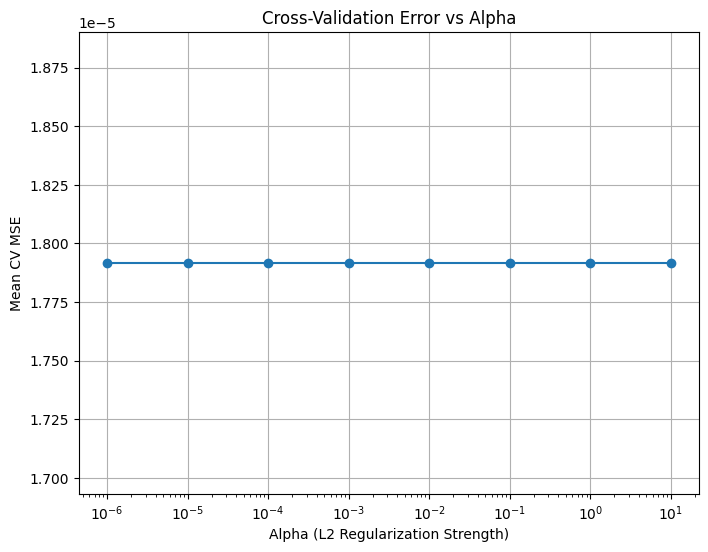

Best alpha (lambda): 1e-06
Best CV Mean RMSE: 0.0042327468953025
Final coefficients: [0.]
Index(['lrf'], dtype='object')
Final intercept: [0.84365979]
0.0038800179873606333
cv_score    0.00388
dtype: float64


C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline

which='cv_score'
todo = np.logical_and(main, np.logical_not(np.isnan(p[which].to_numpy())))
#y = p[[which]][todo].to_numpy()-p[['cv_score']][todo].to_numpy()
y = p[[which]][todo]

# n_ensemble = 1
# X = p[['degrees', 'scale_moving_std_size_fac', 'n_epochs', 'trust_extra', 'absolute_threshold', 'z_range', 'concentration', 'erasing', 'scale_moving_std']][todo]
# X.loc[np.logical_not(p['scale_moving_std'][todo]), 'scale_moving_std_size_fac'] = np.mean(X.loc[(p['scale_moving_std'][todo]), 'scale_moving_std_size_fac'])
# X['trust_neg2'] = (p['trust_neg']==2)[todo]

# n_ensemble = 4 offline
# X = p[['fliplr']][todo]
# X['trust_extra0'] = (p['trust_extra']==0)[todo]
# #X['trust_extra'] = (p['trust_extra']==0)[todo]
# X['yolov8'] = np.logical_or(p['model_name']=='yolov8m',p['model_name']=='yolov8s')

# online
# X = p[['fliplr']][todo]

# ca1 offline
X = p[['lrf']][todo]
# #X['lr0_times_nepochs2'] = X['lr0_times_nepochs']**2
# X['trust_extra0'] = (p['trust_extra']==0)[todo]
# #X['degrees0'] = (p['degrees']==0)[todo]
# #X['img_size2'] = (p['img_size']**2)[todo]
# X['z_range_m1'] = (p['z_range']==-1)[todo]
# X['trust_neg0'] = (p['trust_neg']==0)[todo]
# X['model_8'] = (['8' in x for x in p['model_name'][todo]])
#X['model_11'] = (['11' in x for x in p['model_name']])

# Define candidate alphas (lambdas)
alphas = np.logspace(-6, 1, 8)

# Define pipeline explicitly with named steps
pipeline = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("ridge", sklearn.linear_model.Lasso())
])

# Define parameter grid (for Ridge alpha)
param_grid = {
    "ridge__alpha": alphas
}

# GridSearchCV with 5-fold cross-validation
grid_search = sklearn.model_selection.GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=len(y),
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(X, y)

# Extract results
results = grid_search.cv_results_
mean_test_scores = -results['mean_test_score']  # Convert to positive MSE
alphas_tested = results['param_ridge__alpha'].data.astype(float)

# Plot CV error as function of alpha
plt.figure(figsize=(8, 6))
plt.semilogx(alphas_tested, mean_test_scores, marker='o')
plt.xlabel("Alpha (L2 Regularization Strength)")
plt.ylabel("Mean CV MSE")
plt.title("Cross-Validation Error vs Alpha")
plt.grid(True)
plt.show()

# Report best alpha
best_alpha = grid_search.best_params_['ridge__alpha']
print("Best alpha (lambda):", best_alpha)
print("Best CV Mean RMSE:", np.sqrt(-grid_search.best_score_))

# Create a new pipeline with the best alpha
final_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("lasso", sklearn.linear_model.Lasso(alpha=best_alpha))
])

# Fit to full dataset
final_model.fit(X, y)

y_pred = final_model.predict(X)
p['residual'] = np.nan
#p.loc[todo,'residual'] = (y-y_pred).to_numpy()
p.loc[todo,'residual'] = (np.ravel(y)-y_pred)

# (Optional) Print final coefficients and intercept
lasso_model = final_model.named_steps['lasso']
print("Final coefficients:", lasso_model.coef_)
print(X.columns)
print("Final intercept:", lasso_model.intercept_)

print(np.std(p['residual'][todo]))
print(np.std(y))

In [15]:
import statsmodels.api as sm
X_norm = (X - X.mean()) / X.std(ddof=0)
#X_norm = X
X_const = sm.add_constant(X_norm)
model = sm.OLS(y[main].astype(float), X_const.astype(float)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               cv_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 24 May 2025   Prob (F-statistic):                nan
Time:                        07:57:51   Log-Likelihood:                 49.596
No. Observations:                  12   AIC:                            -97.19
Df Residuals:                      11   BIC:                            -96.71
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lrf           -0.8437      0.001   -721.157      0.0

C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [16]:
#compare_k_cv(y_pred, 'CV score pred')

In [17]:
# X_alt = copy.deepcopy(X)
# for c in X_alt.columns:
#     X_alt[c] = 0
# X_alt['lr0_times_nepochs'] = X['lr0_times_nepochs']
# X_alt['lr0_times_nepochs2'] = X['lr0_times_nepochs']**2
# y_pred_alt = final_model.predict(X_alt)
# plt.scatter(X_alt['lr0_times_nepochs'], y_pred_alt)

In [18]:
p.columns[-6:]

Index(['use_missing_value', 'cv_score', 'cv_score_tom', 'cv_score_other',
       'k_score', 'residual'],
      dtype='object')

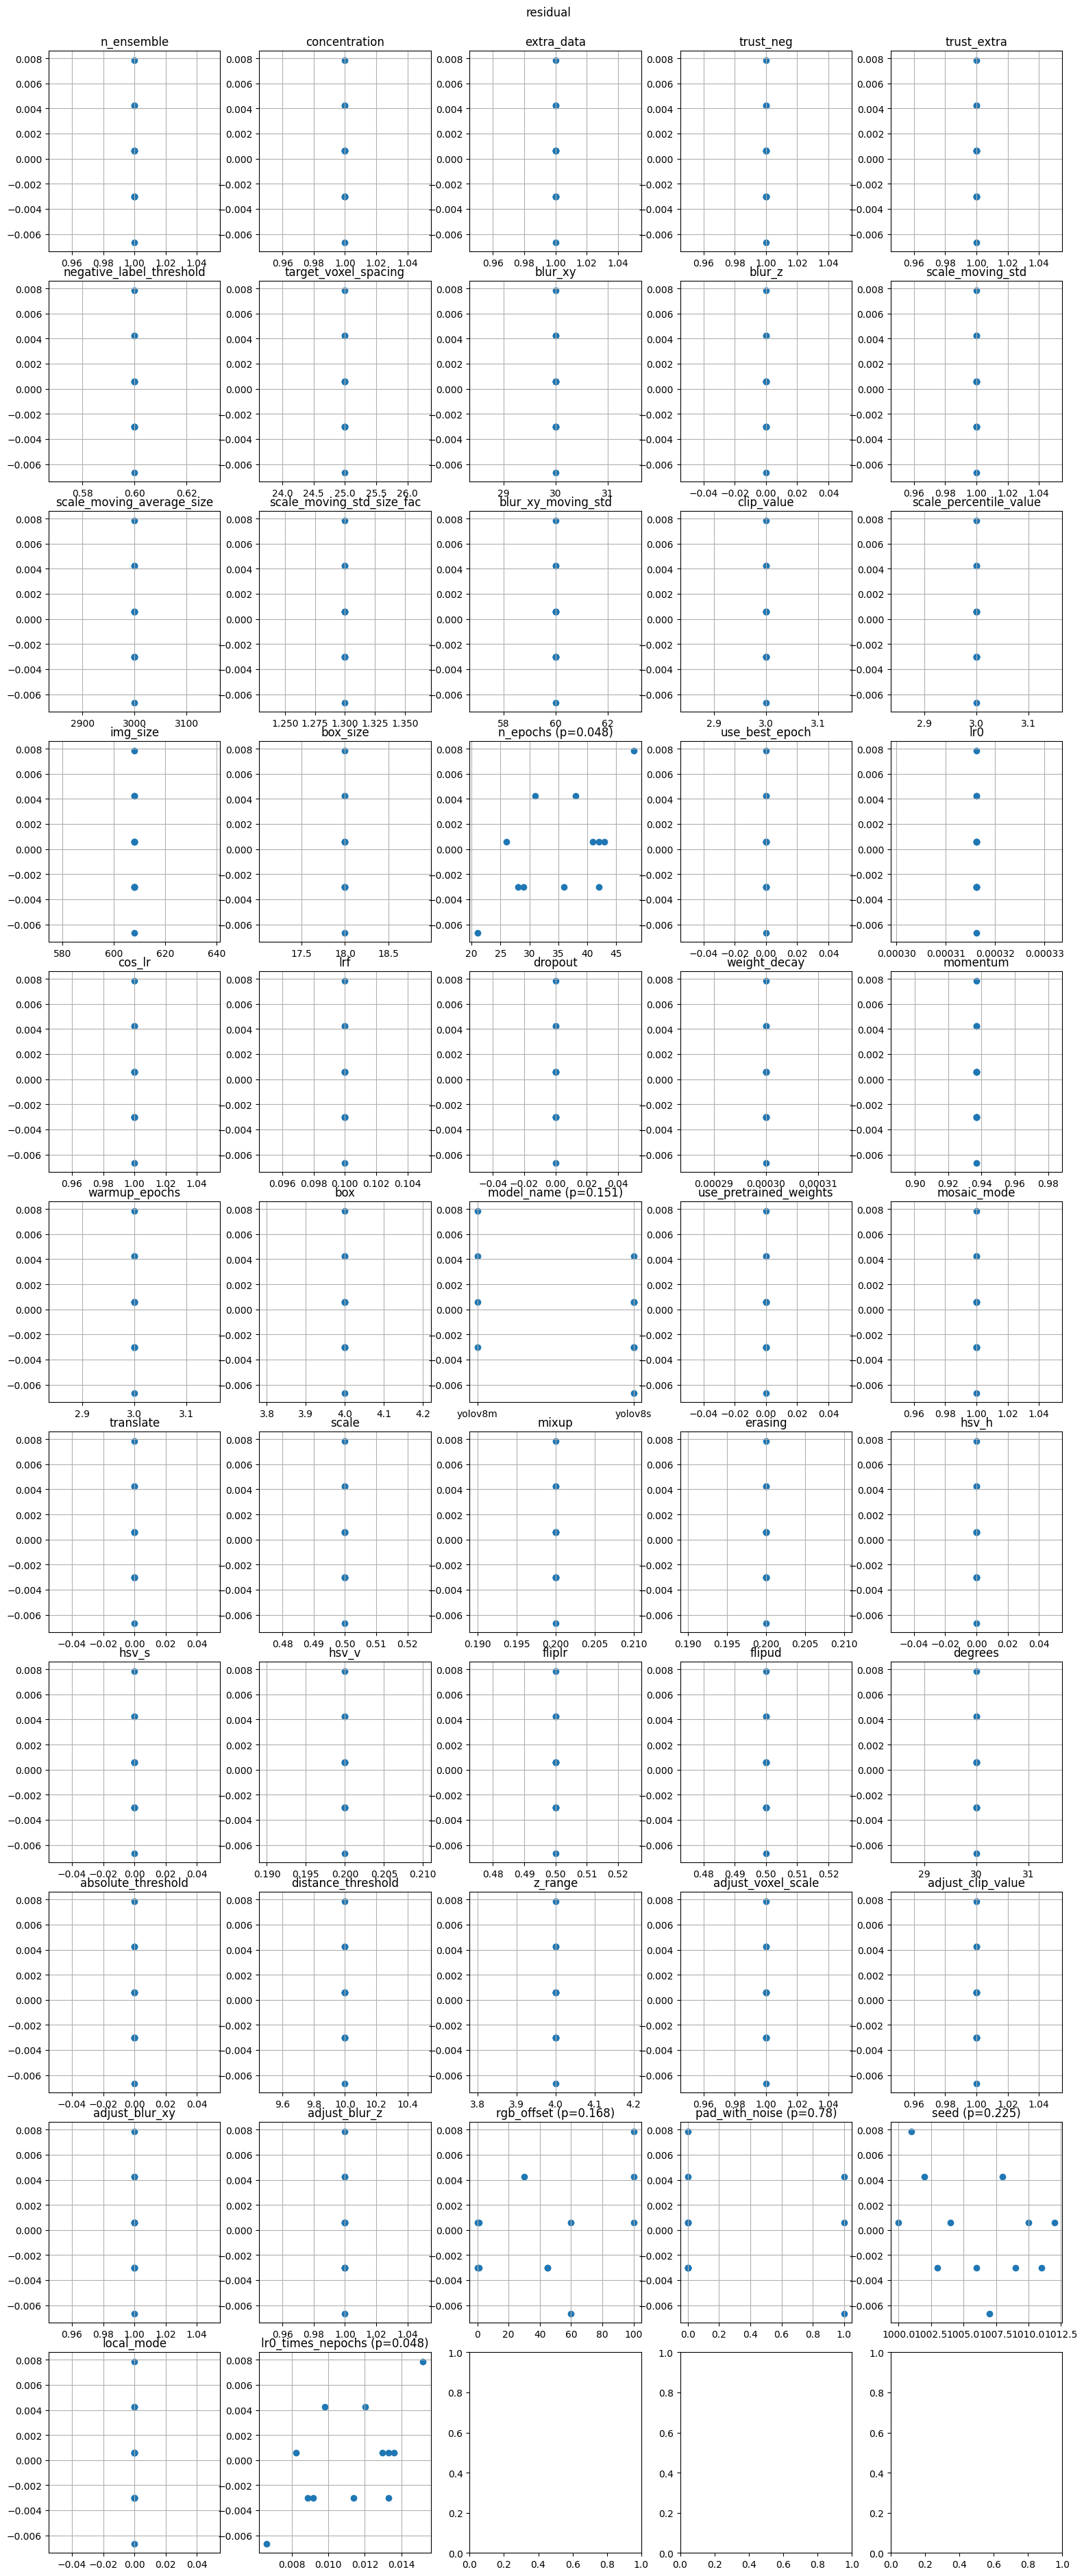

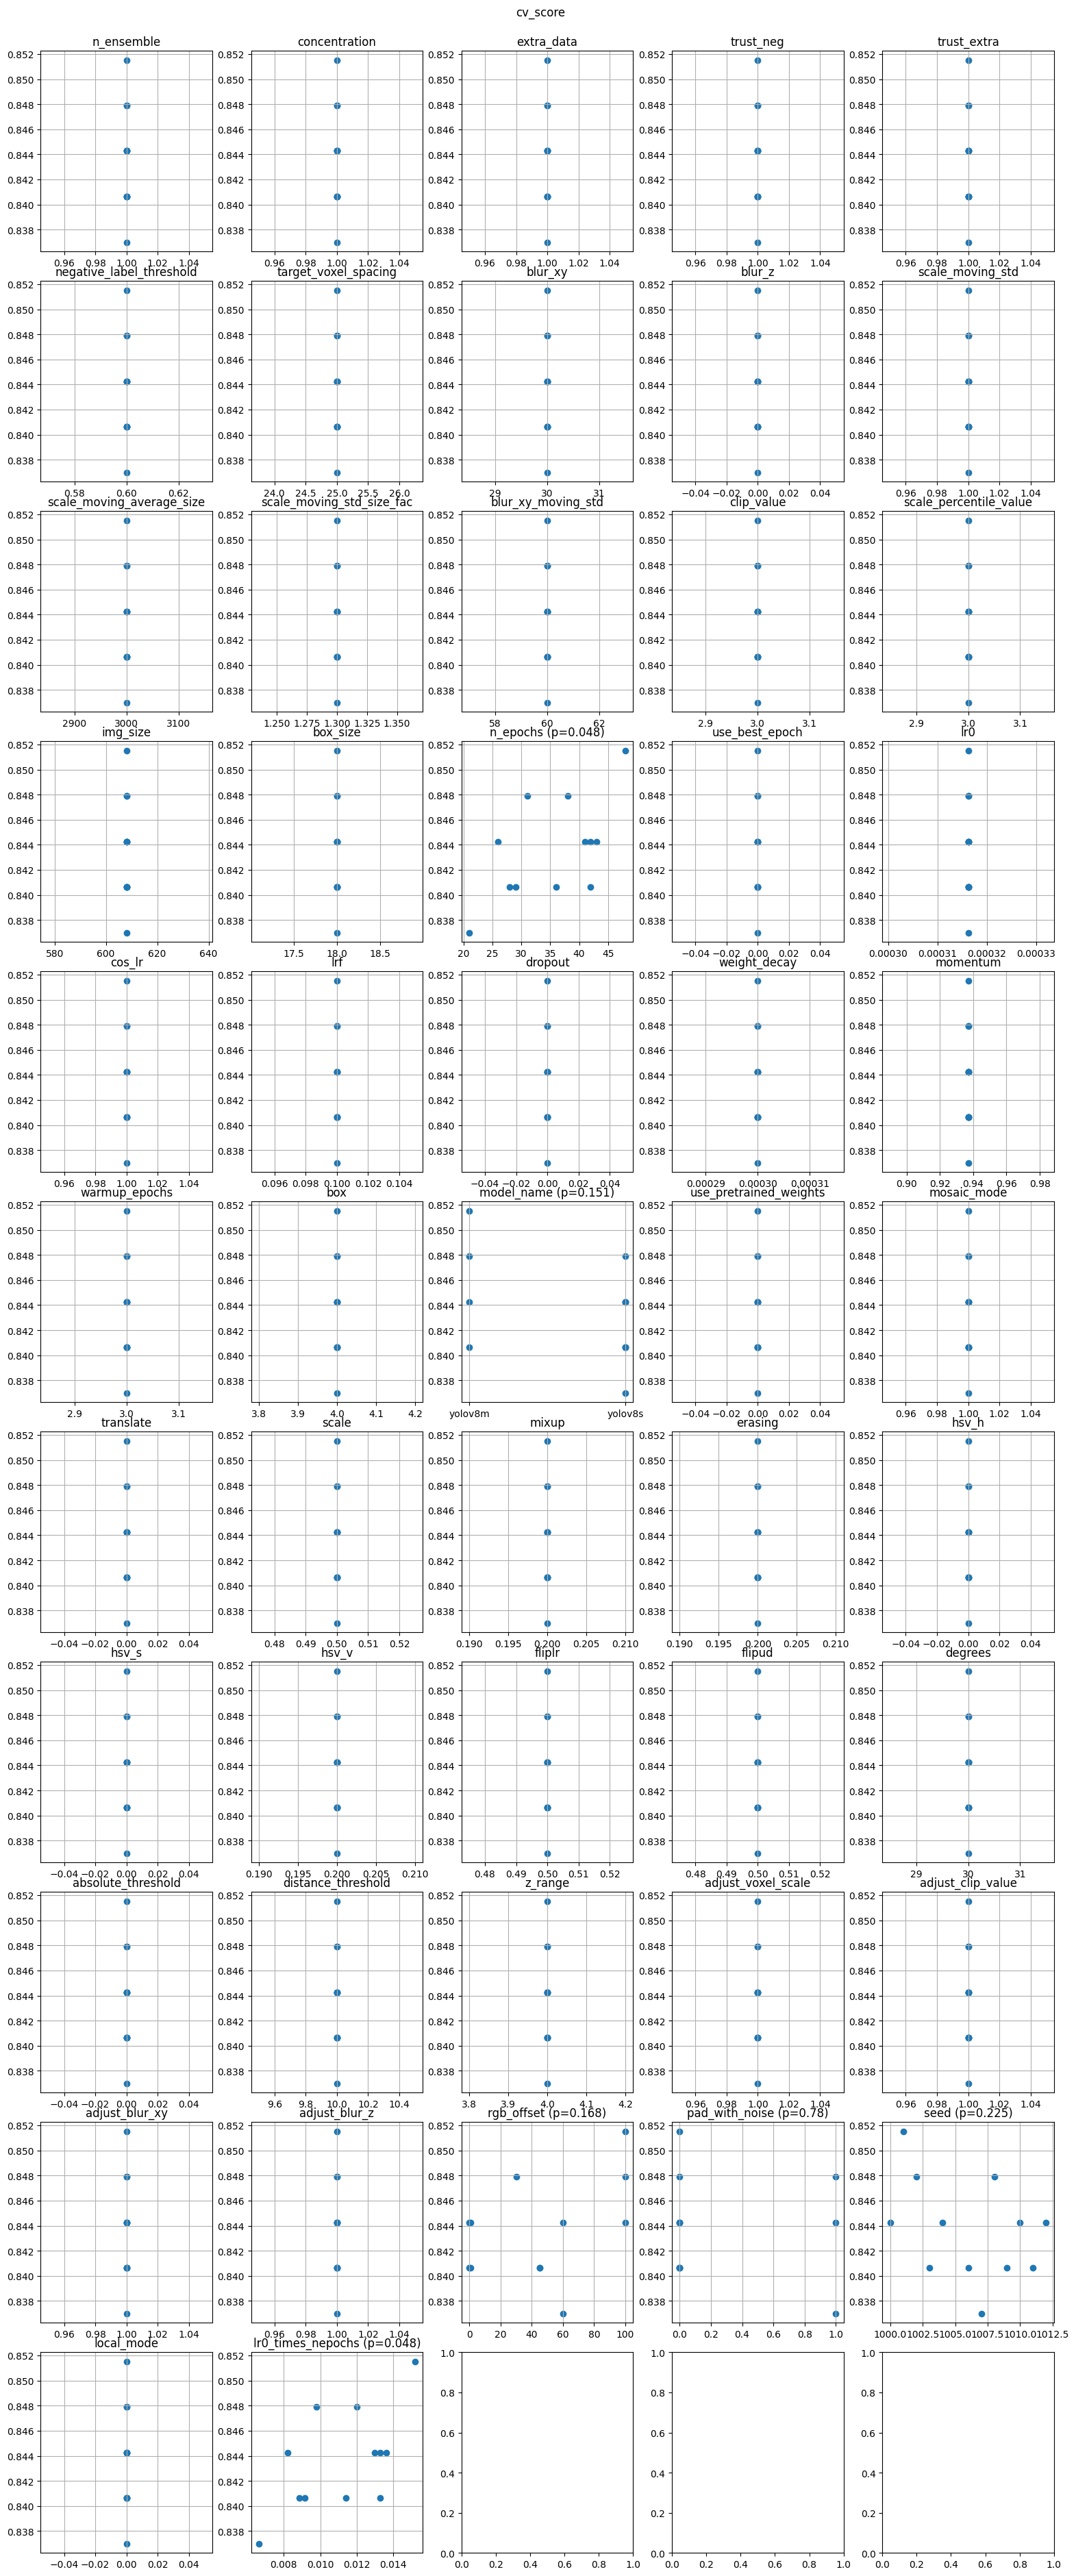

In [19]:
ncols = 5
nrows = len(to_plot)//ncols+1
figs = []
r = np.random.default_rng(seed=0)
#main = p['model_name']=='yolov8l'
for y_val in p.columns[[-1,-5]].to_list():
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18/ncols*nrows))
    plt.tight_layout(pad=10.0,h_pad=1,w_pad=1)
    figs.append(fig)
    plt.suptitle(y_val)
    for idx,d in enumerate(to_plot):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]
        plt.sca(ax)        
        plt.xlabel('')
        plt.ylabel('')
        plt.grid(True)
        #p[y_val] = r.normal(size=p[y_val].shape)
        plt.scatter(p[d][main], p[y_val][main])
        #if y_val == 'k_score':
         #   plt.scatter(p[d][np.logical_not(main)], p[y_val][np.logical_not(main)])
       
        # fit
        if len(np.unique(p[d][main]))>1:
            pp = copy.deepcopy(p)
            if not pd.api.types.is_numeric_dtype(pp[d]) or pd.api.types.is_bool_dtype(pp[d]):
                pp[d] = pp[d].astype('category').cat.codes
            X = pp[[d]][main]
            X['intercept'] = 1.
            y = p[y_val][main]
            to_keep = np.logical_not(np.isnan(y))
            X = X[to_keep]; y=y[to_keep];
            model = sm.OLS(y,X)
            results=model.fit()
            p_val = results.pvalues[d]
            plt.title(f'{d} (p={p_val:.3})')
        else:
            plt.title(d)
        
        # if d == 'mask_sizes0':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][0] for m in model_list]
        # elif d == 'mask_sizes1':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][1] for m in model_list]
        # elif d == 'mask_sizes2':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][2] for m in model_list]
        # else:
        #     x_vals = [getattr(m, d)[model.particles_to_do[0]] for m in model_list]
        # if len(np.unique(x_vals))<8:
        #     #pass
        #     violin_plot(x_vals,score_vals)
        # else:
        #     plt.scatter(x_vals, score_vals)

In [20]:
# from pptx import Presentation
# from pptx.util import Inches

# prs = Presentation()
# blank = prs.slide_layouts[6]  # a blank slide layout

# for i, fig in enumerate(figs):
#     # save each figure to disk
#     img_path = f"figure_{i+1}.png"
#     fig.savefig(img_path, dpi=300, bbox_inches='tight')

#     # add a new slide, then add the image to it
#     slide = prs.slides.add_slide(blank)
#     slide.shapes.add_picture(
#         img_path,
#         Inches(1), Inches(1),          # left, top margins
#         width=Inches(8)                # scale width (height auto)
#     )

#     os.remove(img_path)

# prs.save("run_many_models_results.pptx")